In [1]:
# !pip install spacy
# !python -m spacy download en_core_web_md
# !python -m spacy link en_core_web_md en
# !pip install gensim
# !pip install pyLDAvis
# !python -m spacy download en_core_web_lg
# !python -m spacy link en_core_web_lg en

In [2]:
import matplotlib.pyplot as plt
from project_functions import *
import gensim
import numpy as np
import pandas as pd
import spacy
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import pyLDAvis.gensim
import os, re, operator, warnings
# warnings.filterwarnings('ignore')
%matplotlib inline

---

---

### Load dataframe and Spacy pipeline

In [3]:
df = pd.read_csv('sqr_comments_sentiment.csv')

In [4]:
# Instantiate Spacy's english language pipeline
# Override max length due to large length of characters in documents. Causes large memory usage.
nlp = spacy.load('en_core_web_lg', max_length=5000000)

---

---

### Clean text

In [5]:
# Clean text function from project_functions file. Removes punctuation, whitespace, numbers, and makes text lowercase
cleanText(df, 'comments')

---

---

### Join text as a large string

In [6]:
df.comments.iloc[1]

'wrong person the negative comments dont do justice to ps  our kid is in asd nest program and its been great experience the school is small and welcome the class size is small the teachers are experienced and all the services for special ed are in place the science teacher mr walsh is excellent the school is in the process of building a new playground starting this school year there is no uniform policy only thing that it could improve is communication between the school the teachers with parents its a true hidden gem of district  i suggest that all children go to ps that live around the los or in manhattan i am in th grade right now and i went to ps kindergarten through th grade when i was in ps i was in tap and ballet in rd street music school which is not far from ps and i went to beacon afterschool university settlement across the street from ps  rd grade through th grade and then i started beacon summer camp and every year now beacon dance i loved it the area is not bad either ms 

In [7]:
# Make all the text in the comments column one big string
comments = ''.join(str(df.comments.tolist()))

---

---

### Create tokens

In [8]:
# Process the comments column texts
tokens = nlp(''.join(str(df.comments.tolist())))

In [9]:
# Spacy Doc which is a list of tokens
type(tokens)

spacy.tokens.doc.Doc

In [10]:
# Create token list
token_list = []
for token in tokens:
    token_list.append(token.text)

---

---

### Add and filter stop words

In [11]:
# You can add more stop words at any point then run the cells below again
comments_stop_words = [u'\'s',u'year',u'th',u'nt',u'ps',u' ',u's',u'm',u'  ', u'ms', u'mr',u've',u'gt']
# Loops through each new stopword added
for word in comments_stop_words:
    # Set lexeme to Spacy pipeline's vocab method where each word is passed in
    lexeme = nlp.vocab[word]
    # is_stop method used to add new word to the stopword list
    lexeme.is_stop = True

In [12]:
# Create list of word tokens after removing stopwords
filtered_tokens =[] 
# Loop through token list
for word in token_list:
    # Call vocab 
    lexeme = nlp.vocab[word]
    if lexeme.is_stop == False:
        filtered_tokens.append(word) 

In [13]:
# Find most common entities
tokens_frequency = Counter(filtered_tokens).most_common(20)
tokens_df = pd.DataFrame(tokens_frequency, columns=['text', 'count'])

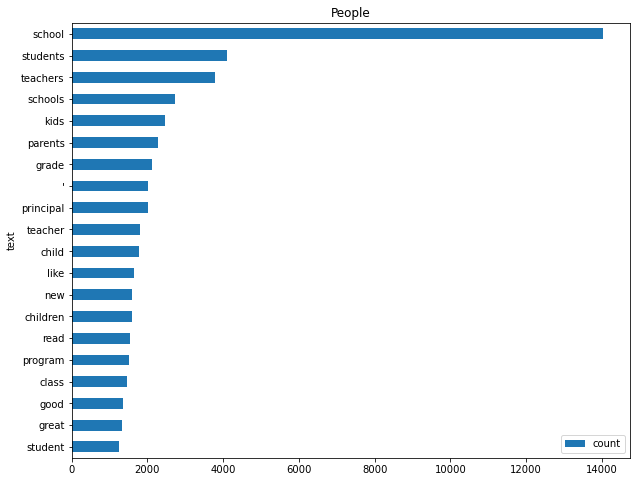

In [14]:
tokens_df.plot.barh(x='text', y='count', title="People", figsize=(10,8)).invert_yaxis()

---

---

### List of lemmas

In [15]:
lemma_list = [] 
for token in tokens:
    lemma_list.append(token.lemma_)

In [16]:
# Find most common entities
lemma_frequency = Counter(lemma_list).most_common(20)
lemma_df = pd.DataFrame(tokens_frequency, columns=['text', 'count'])

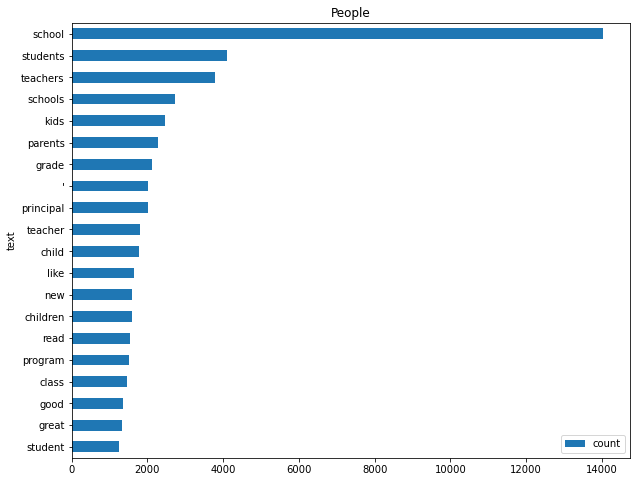

In [17]:
lemma_df.plot.barh(x='text', y='count', title="People", figsize=(10,8)).invert_yaxis()

---

---

### Named Entity Recognition (NER) Categories

**PERSON:**    People, including fictional. <br>
**NORP:**	Nationalities or religious or political groups.<br>
**FAC:**	Buildings, airports, highways, bridges, etc.<br>
**ORG:**	Companies, agencies, institutions, etc.<br>
**GPE:**	Countries, cities, states.<br>
**LOC:**	Non-GPE locations, mountain ranges, bodies of water.<br>
**PRODUCT:**	Objects, vehicles, foods, etc. (Not services.)<br>
**EVENT:**	Named hurricanes, battles, wars, sports events, etc.<br>
**WORK_OF_ART:**	Titles of books, songs, etc.<br>
**LAW:**	Named documents made into laws.<br>
**LANGUAGE:**	Any named language.<br>
**DATE:**	Absolute or relative dates or periods.<br>
**TIME:**	Times smaller than a day.<br>
**PERCENT:**	Percentage, including ”%“.<br>
**MONEY:**	Monetary values, including unit.<br>
**QUANTITY:**	Measurements, as of weight or distance.<br>
**ORDINAL:**	“first”, “second”, etc.<br>
**CARDINAL:**	Numerals that do not fall under another type.<br>


In [18]:
# Create a list of entities 
ents = list(tokens.ents)

In [19]:
# Find most common entities
items = [x.text for x in tokens.ents]
entity_frequency = Counter(items).most_common(20)
entity_df = pd.DataFrame(entity_frequency, columns=['text', 'count'])

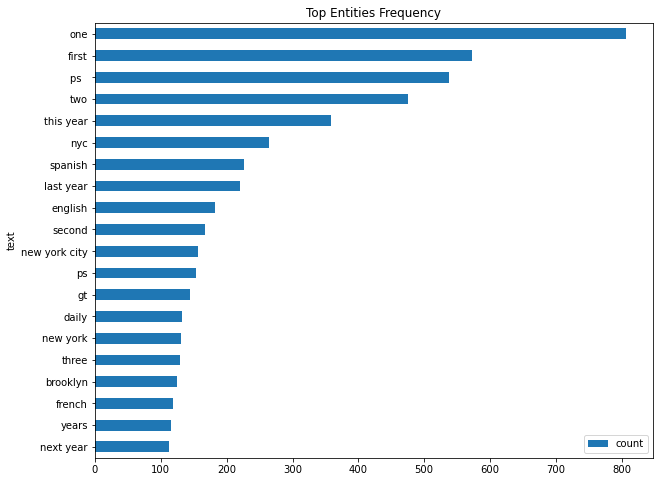

In [20]:
entity_df.plot.barh(x='text', y='count', title='Top Entities Frequency', figsize=(10,8)).invert_yaxis()

### People

In [21]:
# NER for people
person_list = []

for ent in tokens.ents:
    if ent.label_ == 'PERSON':
        person_list.append(ent.text)
        
person_counts = Counter(person_list).most_common(20)
df_person = pd.DataFrame(person_counts, columns =['text', 'count'])

Shugan Wen school is a high performing dual language k-8 in Manhattan

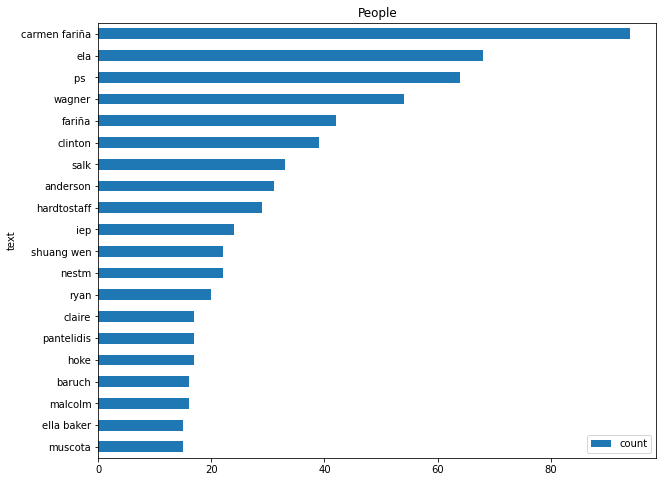

In [22]:
df_person.plot.barh(x='text', y='count', title="People", figsize=(10,8)).invert_yaxis()

### Nationalities or Religious/Political Groups

There are no recognized nationalities or religious/political groups.

In [23]:
# NER for nationalities or religious or political groups 
norp_list = []

for ent in tokens.ents:
    if ent.label_ == 'NORP':
        person_list.append(ent.text)
        
norp_counts = Counter(norp_list).most_common(20)
df_norp = pd.DataFrame(norp_counts, columns =['entity', 'count'])
df_norp

,entity,count


---

---

### Noun Chunks

In [24]:
# Find most common noun chunks
noun_chunks = [x.text for x in tokens.noun_chunks]
noun_chunks_frequency = Counter(noun_chunks).most_common(20)
noun_chunks_df = pd.DataFrame(noun_chunks_frequency, columns=['text', 'count'])

In [25]:
noun_chunks_df

,text,count
0,i,11845
1,you,4869
2,it,4771
3,they,4299
4,the school,3272
5,we,3061
6,this school,2735
7,she,2164
8,who,2100
9,he,1701


---

---

### Sentence Boundaries

In [26]:
# Sentence boundary
sentence = [x.root.text for x in tokens.sents]
sentence_frequency = Counter(sentence).most_common(20)
sentence_df = pd.DataFrame(sentence_frequency, columns=['text', 'count'])

In [27]:
sentence_df

,text,count
0,is,4656
1,are,1620
2,was,1321
3,have,900
4,am,514
5,had,479
6,be,462
7,m,437
8,know,434
9,think,419


---

---

### Document cosine similarity 

In [28]:
# apples = nlp("I like apples")
# oranges = nlp("I like oranges")
# apples_oranges = apples.similarity(oranges)
# oranges_apples = oranges.similarity(apples)
# assert apples_oranges == oranges_apples